## Walmart sales - packaged models

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from plotnine import *

from IPython.display import display
from tqdm import tqdm_notebook as tqdm

from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Dataframes

In [3]:
df = pd.read_csv('data/processed/all.csv')

df['Date'] = pd.to_datetime(df['Date'])

holidays = sorted(df.query('IsHoliday==True').DateString.unique())
stores = sorted(df.Store.unique())

Building dataframes for a single store, which will be useful to study the data

In [4]:
df1 = df.copy().query("Store==1 and Train")
df1_idx = df1.set_index(['Date'])
df1_sales = df1_idx['WeeklySales']

### Facebook's Prophet

In [5]:
from fbprophet import Prophet

dfp = pd.DataFrame()

for store in tqdm(stores):

    dfs = df[df.Store==store][['Date', 'WeeklySales', 'Store', 'IsHoliday']]
    df_prophet = dfs.copy().rename(columns={'Date':'ds', 'WeeklySales':'y'})

    m = Prophet(weekly_seasonality=False)
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods=40, freq='W')
    forecast = m.predict(future)

    dff = forecast.copy()[['ds','yhat']].rename(columns={'ds':'Date', 'yhat':'WeeklySalesForecast'})
    dfs = pd.merge(dfs, dff, on='Date', how='outer')
    dfp = pd.concat([dfp, dfs])

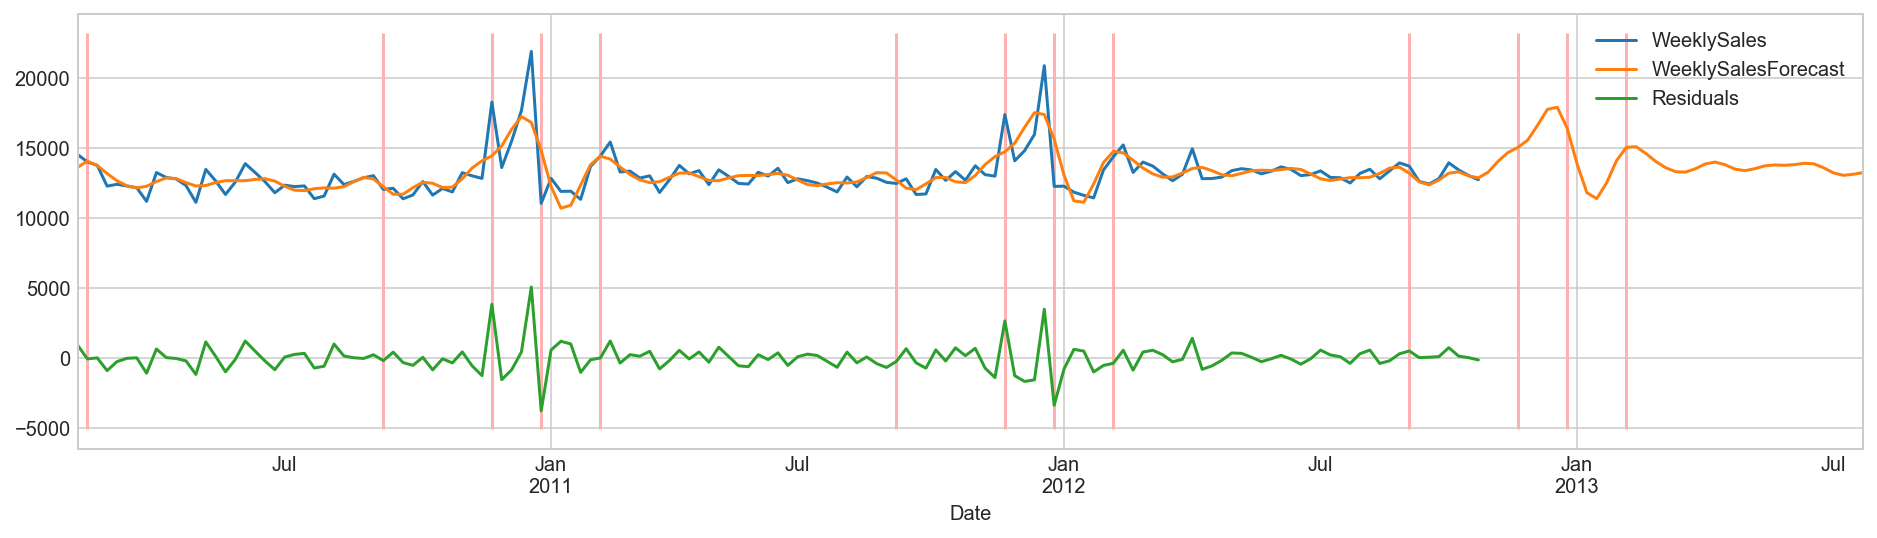

In [6]:
dfp['Residuals'] = dfp.WeeklySales - dfp.WeeklySalesForecast
ax = dfp[dfp.Store==8].plot(x='Date', y=['WeeklySales','WeeklySalesForecast', 'Residuals'], figsize=(16,4))
ymin, ymax = ax.get_ylim()
ax.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')

In [7]:
y_actual = dfp.WeeklySales
y_pred = dfp.WeeklySalesForecast
w = dfp.IsHoliday.map(lambda v: 5 if v else 1).values

rmse = np.sqrt(np.mean((y_pred-y_actual)**2))    
wmae = np.sum(w*(y_pred-y_actual)) / np.sum(w)
mae = np.mean(np.abs(y_pred-y_actual))

print("MAE=%s WMAE=%s RMSE=%s" % (mae, wmae, rmse))

MAE=817.161539056 WMAE=-13.7695188603 RMSE=1423.12216224
